In [26]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [51]:
!nvidia-smi

Sat Oct 14 22:09:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8               3W /  50W |   1896MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = '../dataset/train/'
test_dir = '../dataset/validation/'

IMG_SIZE = 224
seed = 123
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.25,
  subset="training",
    seed = 123,
  batch_size=BATCH_SIZE
)

val_ds  = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.25,
  subset="validation",
  seed=seed,
  batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=seed,
  batch_size=BATCH_SIZE
)

Found 2100 files belonging to 6 classes.
Using 1575 files for training.
Found 2100 files belonging to 6 classes.
Using 525 files for validation.
Found 528 files belonging to 6 classes.


In [53]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


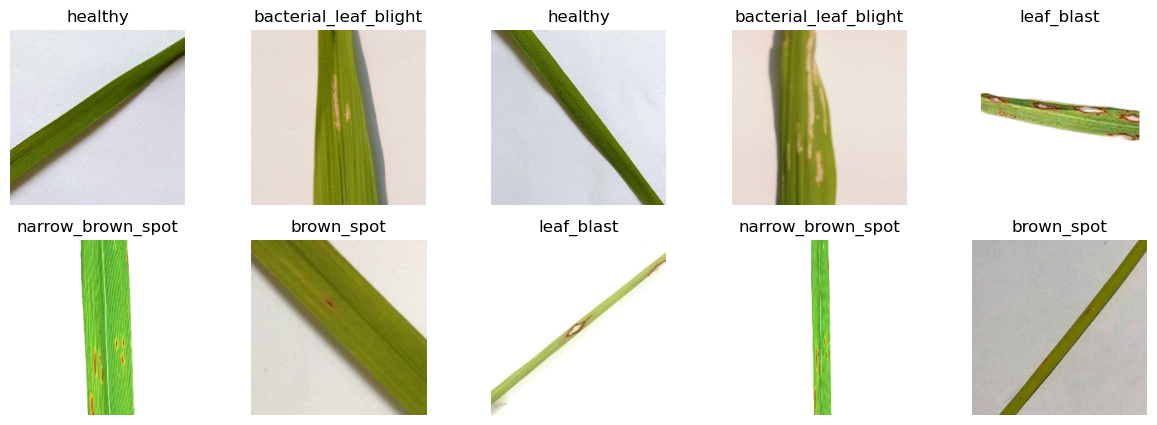

In [54]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [75]:
class RiceLeafDetection(tf.keras.Model):
    def __init__(self, num_classes=3):
        super(RiceLeafDetection, self).__init__()
        self.mobilenet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
        self.flatten = layers.Flatten()
        #self.d1 = layers.Dense(64, activation='relu')
        self.d2 = layers.Dense(32, activation='linear')
        self.d3 = layers.Dense(num_classes, activation='linear')

    
    def call(self, x):
        x = tf.keras.applications.mobilenet.preprocess_input(x)
        x = self.mobilenet(x)
        x = self.flatten(x)
        x = layers.Dropout(0.2)(x)
        x = self.d2(x)
        return self.d3(x)

In [70]:
data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2, fill_mode='constant'),
        layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant'),
        layers.RandomContrast(factor=0.2),
        layers.RandomBrightness(factor=0.0005),
    ])

In [38]:
tf.get_logger().setLevel('ERROR')
image, label = next(iter(train_ds))
image = image[0]/255
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

ResourceExhaustedError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[1600,1600,3] and type uint8 on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext]

In [71]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds,shuffle = False,augment = False):
    if shuffle:
        ds = ds.shuffle(1024)
    if augment:
        ds = ds.map(lambda x,y:(data_augmentation(x,training = True),y),num_parallel_calls = AUTOTUNE)

    return ds.prefetch(buffer_size = AUTOTUNE)

In [72]:
train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [76]:
mlp = RiceLeafDetection(num_classes=6)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)
#freeze the base model
mlp.mobilenet.trainable = False
mlp.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_filepath = '../tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [77]:
epochs=1000
history = mlp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback,model_checkpoint_callback]
)

Epoch 1/1000


99/99 [==============================] - 16s 81ms/step - loss: 8.3467 - accuracy: 0.7708 - val_loss: 6.6205 - val_accuracy: 0.8190
Epoch 2/1000
99/99 [==============================] - 10s 63ms/step - loss: 2.6852 - accuracy: 0.9181 - val_loss: 6.2424 - val_accuracy: 0.8876
Epoch 3/1000
99/99 [==============================] - 9s 63ms/step - loss: 1.2463 - accuracy: 0.9530 - val_loss: 4.6884 - val_accuracy: 0.8933
Epoch 4/1000
99/99 [==============================] - 10s 63ms/step - loss: 0.4748 - accuracy: 0.9803 - val_loss: 2.9264 - val_accuracy: 0.9219
Epoch 5/1000
99/99 [==============================] - 9s 59ms/step - loss: 0.4889 - accuracy: 0.9816 - val_loss: 4.9084 - val_accuracy: 0.8857
Epoch 6/1000
99/99 [==============================] - 9s 61ms/step - loss: 0.9084 - accuracy: 0.9702 - val_loss: 3.0591 - val_accuracy: 0.9429
Epoch 7/1000
99/99 [==============================] - 9s 61ms/step - loss: 0.4497 - accuracy: 0.9784 - val_loss: 3.3577 - val_accuracy: 0.9219


In [80]:
checkpoint = tf.train.Checkpoint(model=mlp)
checkpoint.restore(checkpoint_filepath)

In [81]:
mlp.evaluate(val_ds)

33/33 [==============================] - 3s 52ms/step - loss: 2.9264 - accuracy: 0.9219


[2.926353931427002, 0.9219047427177429]

In [79]:
# save subclass model
mlp.save('mobilenetv2', save_format='tf')

In [82]:
test_model = keras.models.load_model('mobilenetv2')

In [84]:
from PIL import Image
import numpy as np

image = Image.open('../dataset/train/bacterial_leaf_blight/bacterial_leaf_blight (1).JPG')
image = image.resize((256,256))
image_array = np.array(image)
image_tensor = tf.cast(image_array, tf.float32)
image_tensor = tf.expand_dims(image_tensor, 0)
test_model.predict(image_tensor)

1/1 [==============================] - 1s 654ms/step


array([[193.50302 , -90.44145 , -79.27981 , -43.289085, -46.0301  ,
        -32.717663]], dtype=float32)

In [83]:
test_model.summary()

Model: "rice_leaf_detection_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 flatten_6 (Flatten)         multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  2621472   
                                                                 
 dense_9 (Dense)             multiple                  198       
                                                                 


Total params: 4,879,654
Trainable params: 2,621,670
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
#get 1 image from test dataset
image, label = next(iter(test_ds))
image = image[0]

In [22]:
image

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[247.23438, 253.23438, 243.23438],
        [246.95312, 252.95312, 242.95312],
        [249.25   , 254.625  , 244.875  ],
        ...,
        [185.25   , 186.75   , 180.625  ],
        [175.32812, 176.32812, 168.32812],
        [180.67188, 181.67188, 173.67188]],

       [[249.625  , 255.     , 245.625  ],
        [245.875  , 251.875  , 241.875  ],
        [248.39062, 253.76562, 244.01562],
        ...,
        [186.1875 , 187.6875 , 181.5625 ],
        [178.     , 179.     , 171.     ],
        [176.92188, 177.92188, 169.92188]],

       [[250.03125, 254.57812, 245.32812],
        [248.5    , 253.76562, 244.26562],
        [251.5625 , 253.98438, 245.54688],
        ...,
        [185.20312, 186.42188, 178.5625 ],
        [182.32812, 183.32812, 175.32812],
        [176.15625, 177.15625, 169.15625]],

       ...,

       [[254.125  , 255.     , 249.25   ],
        [254.875  , 255.     , 250.     ],
        [254.89062, 255.   

In [21]:
test_model.predict(tf.expand_dims(image, 0))

1/1 [==============================] - 0s 108ms/step


array([[  3.705672 ,  16.802706 ,  -2.6323872,   8.622542 , -19.202345 ,
         -5.0386515]], dtype=float32)

In [37]:
#add 1 dimension to image
image = tf.expand_dims(image, 0)
image.shape

TensorShape([1, 256, 256, 3])

In [47]:
train_ds.class_names

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

In [49]:
import numpy as np
train_ds.class_names[np.argmax(test_model.predict(image))]

1/1 [==============================] - 0s 64ms/step


'leaf_scald'